In [1]:
from pathlib import Path
from typing import Dict

from dask import dataframe as dd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pearl.post_processing.bmi import (
    add_overall,
    calc_risk_by_group,
    clean_control,
    group_title_dict,
)


In [2]:
num_samples = 2000
#baseline = Path("/workspaces/pearlModel/out/1000_SA/S0_1000/combined")
#variable = Path("/workspaces/pearlModel/out/1000_SA/S3_1000/combined")
#baseline_sa = Path("/workspaces/pearlModel/out/1000_SA/S0_SA_1000/combined")
#variable_sa = Path("/workspaces/pearlModel/out/1000_SA/S3_SA_1000/combined")

baseline = Path("/workspaces/pearlModel/out/S0_10/combined")
variable = Path("/workspaces/pearlModel/out/S3_10/combined")
baseline_sa = Path("/workspaces/pearlModel/out/S0_SA_10/combined")
variable_sa = Path("/workspaces/pearlModel/out/S3_SA_10/combined")

In [3]:
target_columns = ['dm_prevalence_prev',
                  'dm_prevalence',
                  'dm_incidence',
                  'pre_art_bmi',
                  'post_art_bmi',
                  'art_initiators']

In [4]:
param_df_baseline = pd.read_parquet(baseline / "parameters.parquet").reset_index(drop=True)
param_df_variable = pd.read_parquet(variable / "parameters.parquet").reset_index(drop=True)
param_df_baseline_sa = pd.read_parquet(baseline_sa / "parameters.parquet").reset_index(drop=True)
param_df_variable_sa = pd.read_parquet(variable_sa / "parameters.parquet").reset_index(drop=True)

In [5]:
def add_overall_to_params(params):
    group = params['group'].unique()[1]
    overall = params[params['group']==group]
    overall['group'] = 'overall'
    params = pd.concat([params, overall])
    return params.reset_index(drop=True)

In [6]:
param_df_baseline_sa.columns

Index(['replication', 'group', 'new_dx', 'final_year', 'mortality_model',
       'mortality_threshold_flag', 'idu_threshold', 'seed',
       'bmi_intervention_scenario', 'bmi_intervention_start_year',
       'bmi_intervention_end_year', 'bmi_intervention_coverage',
       'bmi_intervention_effectiveness', 'dm_prevalence_prev', 'dm_prevalence',
       'dm_incidence', 'pre_art_bmi', 'post_art_bmi', 'art_initiators'],
      dtype='object')

In [7]:
# add overall to params
param_df_baseline = add_overall_to_params(param_df_baseline)
param_df_variable = add_overall_to_params(param_df_variable)
param_df_baseline_sa = add_overall_to_params(param_df_baseline_sa)
param_df_variable_sa = add_overall_to_params(param_df_variable_sa)

/tmp/ipykernel_17684/2444569115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall['group'] = 'overall'
/tmp/ipykernel_17684/2444569115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall['group'] = 'overall'
/tmp/ipykernel_17684/2444569115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

### First lets look at the differences between the sensitivity analysis run and the unaltered runs in the S0 scenario

In [8]:
# load the baseline data
bmi_int_dm_prev_baseline = dd.read_parquet(baseline / "dm_final_output.parquet")
bmi_int_dm_prev_baseline_sa = dd.read_parquet(baseline_sa / "dm_final_output.parquet")

In [9]:
# load the baseline data
bmi_int_dm_prev_baseline = dd.read_parquet(baseline / "dm_final_output.parquet")
bmi_int_dm_prev_baseline_sa = dd.read_parquet(baseline_sa / "dm_final_output.parquet")

# reduce to manageable subset
bmi_int_dm_prev_baseline = bmi_int_dm_prev_baseline[bmi_int_dm_prev_baseline['replication'] < 20]
bmi_int_dm_prev_baseline_sa = bmi_int_dm_prev_baseline_sa[bmi_int_dm_prev_baseline_sa['replication'] <20]

In [10]:
# add overall
bmi_int_dm_prev_baseline = add_overall(bmi_int_dm_prev_baseline)
bmi_int_dm_prev_baseline_sa = add_overall(bmi_int_dm_prev_baseline_sa)

In [11]:
# clean to control specifications
control_bmi_int_dm_prev_baseline = clean_control(bmi_int_dm_prev_baseline, only_eligible=True, only_received=True)
control_bmi_int_dm_prev_baseline_sa = clean_control(bmi_int_dm_prev_baseline_sa, only_eligible=True, only_received=True)

# filter for only people eligible for intervention
bmi_int_eligible_risk_baseline = calc_risk_by_group(control_bmi_int_dm_prev_baseline, 7).compute()
bmi_int_eligible_risk_baseline_sa = calc_risk_by_group(control_bmi_int_dm_prev_baseline_sa, 7).compute()

In [12]:
baseline_risk_median = bmi_int_eligible_risk_baseline.groupby('group')['risk'].median().reset_index()
baseline_risk_median

,group,risk
0,het_black_female,24.162827
1,het_black_male,18.323582
2,het_hisp_female,22.106310
3,het_hisp_male,17.912025
4,het_white_female,23.008842
5,het_white_male,16.658779
6,idu_black_female,26.665600
7,idu_black_male,14.933613
8,idu_hisp_female,28.634068
9,idu_hisp_male,9.483428


In [13]:
baseline_risk_sa_median = bmi_int_eligible_risk_baseline_sa.groupby('group')['risk'].median().reset_index()
baseline_risk_sa_median

,group,risk
0,het_black_female,22.858503
1,het_black_male,18.482518
2,het_hisp_female,20.881247
3,het_hisp_male,16.654228
4,het_white_female,21.626651
5,het_white_male,16.562302
6,idu_black_female,24.964166
7,idu_black_male,12.670854
8,idu_hisp_female,27.846748
9,idu_hisp_male,9.546101


In [14]:
((baseline_risk_sa_median['risk'] - baseline_risk_median['risk']) / baseline_risk_median['risk']) * 100

0     -5.398059
1      0.867385
2     -5.541691
3     -7.022083
4     -6.007218
5     -0.579135
6     -6.380632
7    -15.152119
8     -2.749593
9      0.660873
10     2.360767
11    11.442070
12    -4.086510
13    -9.242780
14    -5.378849
15    -5.040877
Name: risk, dtype: float64

### Let's do the same for the intervention run

In [15]:
# load the variable data
bmi_int_dm_prev_variable = dd.read_parquet(variable / "dm_final_output.parquet")
bmi_int_dm_prev_variable_sa = dd.read_parquet(variable_sa / "dm_final_output.parquet")

# add overall
bmi_int_dm_prev_variable = add_overall(bmi_int_dm_prev_variable)
bmi_int_dm_prev_variable_sa = add_overall(bmi_int_dm_prev_variable_sa)

In [16]:
# clean to control specifications
control_bmi_int_dm_prev_variable = clean_control(bmi_int_dm_prev_variable, only_eligible=True, only_received=True)
control_bmi_int_dm_prev_variable_sa = clean_control(bmi_int_dm_prev_variable_sa, only_eligible=True, only_received=True)

# filter for only people eligible for intervention
bmi_int_eligible_risk_variable = calc_risk_by_group(control_bmi_int_dm_prev_variable, 7).compute()
bmi_int_eligible_risk_variable_sa = calc_risk_by_group(control_bmi_int_dm_prev_variable_sa, 7).compute()

In [17]:
variable_risk_median = bmi_int_eligible_risk_variable.groupby('group')['risk'].median().reset_index()
variable_risk_median

,group,risk
0,het_black_female,18.971517
1,het_black_male,14.232752
2,het_hisp_female,18.195128
3,het_hisp_male,13.007603
4,het_white_female,17.936249
5,het_white_male,12.306002
6,idu_black_female,22.942336
7,idu_black_male,11.143292
8,idu_hisp_female,22.138216
9,idu_hisp_male,8.514785


In [18]:
variable_risk_sa_median = bmi_int_eligible_risk_variable_sa.groupby('group')['risk'].median().reset_index()
variable_risk_sa_median

,group,risk
0,het_black_female,19.007923
1,het_black_male,14.961056
2,het_hisp_female,18.055139
3,het_hisp_male,13.075447
4,het_white_female,18.471826
5,het_white_male,12.596988
6,idu_black_female,23.188077
7,idu_black_male,10.815052
8,idu_hisp_female,22.369028
9,idu_hisp_male,8.783215


In [19]:
((variable_risk_sa_median['risk'] - variable_risk_median['risk']) / variable_risk_median['risk']) * 100

0     0.191899
1     5.117099
2    -0.769374
3     0.521571
4     2.986007
5     2.364582
6     1.071123
7    -2.945632
8     1.042597
9     3.152512
10   -4.628395
11    5.863457
12    1.577781
13   -0.166267
14    2.101318
15    1.694430
Name: risk, dtype: float64

### Now let us look at the risk differences for non SA

In [20]:
# gather samples from each non SA run
baseline_risk = bmi_int_eligible_risk_baseline.groupby('group').sample(num_samples, replace=True).reset_index()
variable_risk = bmi_int_eligible_risk_variable.groupby('group').sample(num_samples, replace=True).reset_index()

In [21]:
# absolute difference
risk_df = pd.DataFrame(variable_risk['risk'] - baseline_risk['risk'])

# relative difference
risk_df_relative = pd.DataFrame((variable_risk['risk'] - baseline_risk['risk'])/baseline_risk['risk'])

# add back the group column that is lost
risk_df['group'] = baseline_risk['group']
risk_df_relative['group'] = baseline_risk['group']

In [22]:
# take the median across groups
baseline_risk_difference_df = risk_df.groupby('group').median().reset_index()
baseline_risk_difference_df_relative = risk_df_relative.groupby('group').median().reset_index()

In [23]:
baseline_risk_difference_df

,group,risk
0,het_black_female,-5.223378
1,het_black_male,-4.059302
2,het_hisp_female,-3.906590
3,het_hisp_male,-5.117828
4,het_white_female,-4.423821
5,het_white_male,-4.270186
6,idu_black_female,-3.929260
7,idu_black_male,-3.990298
8,idu_hisp_female,-6.041413
9,idu_hisp_male,-0.796454


### And the same for SA

In [24]:
# gather samples from each SA run
baseline_risk_sa = bmi_int_eligible_risk_baseline_sa.groupby('group').sample(num_samples, replace=True).reset_index()
variable_risk_sa = bmi_int_eligible_risk_variable_sa.groupby('group').sample(num_samples, replace=True).reset_index()

In [25]:
# absolute difference
risk_df_sa = pd.DataFrame(variable_risk_sa['risk'] - baseline_risk_sa['risk'])

# relative difference
risk_df_sa_relative = pd.DataFrame((variable_risk_sa['risk'] - baseline_risk_sa['risk'])/baseline_risk_sa['risk'])

# add back the group column that is lost
risk_df_sa['group'] = baseline_risk_sa['group']
risk_df_sa_relative['group'] = baseline_risk_sa['group']

In [26]:
# take the median across groups
baseline_risk_difference_df_sa = risk_df_sa.groupby('group').median().reset_index()
baseline_risk_difference_df_sa_relative = risk_df_sa_relative.groupby('group').median().reset_index()

In [27]:
baseline_risk_difference_df_sa

,group,risk
0,het_black_female,-3.394553
1,het_black_male,-3.175839
2,het_hisp_female,-3.067104
3,het_hisp_male,-4.669760
4,het_white_female,-3.595518
5,het_white_male,-3.324361
6,idu_black_female,-3.688162
7,idu_black_male,-2.220034
8,idu_hisp_female,-5.042017
9,idu_hisp_male,-0.956275


### SA Tornado plots

In [28]:
def calc_tornado_vals(baseline_risk_df,
                      variable_risk_df,
                      param_df_baseline,
                      param_df_variable,
                      col_name,
                      num_samples=1000,
                      lesser=0.1,
                      greater=0.9):
    
    sub_param_baseline = param_df_baseline[['replication', 'group', col_name]]
    sub_param_variable = param_df_variable[['replication', 'group', col_name]]
    
    baseline_merged = sub_param_baseline.merge(baseline_risk_df, on=['replication', 'group'], how='left').fillna(0)
    variable_merged = sub_param_variable.merge(variable_risk_df, on=['replication', 'group'], how='left').fillna(0)
    
    quantile_val_baseline = baseline_merged.groupby('group')[col_name].quantile([lesser, greater]).unstack().reset_index()
    quantile_val_variable = variable_merged.groupby('group')[col_name].quantile([lesser, greater]).unstack().reset_index()
    
    difference_tornado_df = []
    relative_tornado_df = []
    baseline_tornado_df = []
    variable_tornado_df = []
    for group in quantile_val_baseline['group'].unique():
        group_df_baseline = baseline_merged[baseline_merged['group'] == group]
        group_df_variable = variable_merged[variable_merged['group'] == group]

        lesser_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][lesser].values[0]
        greater_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][greater].values[0]
        lesser_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][lesser].values[0]
        greater_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][greater].values[0]
        
        lesser_group_df_baseline = group_df_baseline[group_df_baseline[col_name] <= lesser_val_baseline]
        greater_group_df_baseline = group_df_baseline[group_df_baseline[col_name] >= greater_val_baseline]
        lesser_group_df_variable = group_df_variable[group_df_variable[col_name] <= lesser_val_variable]
        greater_group_df_variable = group_df_variable[group_df_variable[col_name] >= greater_val_variable]
        
        lesser_group_df_baseline_sample = lesser_group_df_baseline.sample(num_samples, replace=True).reset_index()
        greater_group_df_baseline_sample = greater_group_df_baseline.sample(num_samples, replace=True).reset_index()
        lesser_group_df_variable_sample = lesser_group_df_variable.sample(num_samples, replace=True).reset_index()
        greater_group_df_variable_sample = greater_group_df_variable.sample(num_samples, replace=True).reset_index()
        
        baseline_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_baseline_sample['risk']).quantile([lesser,0.5,greater]),
            greater: (greater_group_df_baseline_sample['risk']).quantile([lesser,0.5,greater]),
            'lesser_count': lesser_group_df_baseline['risk'].count(),
            'greater_count': greater_group_df_baseline['risk'].count(),
        }
        baseline_tornado_df.append(baseline_group_tornado_df)
        variable_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_variable_sample['risk']).quantile([lesser,0.5,greater]),
            greater: (greater_group_df_variable_sample['risk']).quantile([lesser,0.5,greater]),
            'lesser_count': lesser_group_df_variable['risk'].count(),
            'greater_count': greater_group_df_variable['risk'].count(),
        }
        variable_tornado_df.append(variable_group_tornado_df)
        difference_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_variable_sample['risk'] - lesser_group_df_baseline_sample['risk']).quantile([lesser,0.5,greater]),
            greater: (greater_group_df_variable_sample['risk'] - greater_group_df_baseline_sample['risk']).quantile([lesser,0.5,greater])
        }
        difference_tornado_df.append(difference_group_tornado_df)
        
        relative_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: ((lesser_group_df_variable_sample['risk'] - lesser_group_df_baseline_sample['risk'])/lesser_group_df_baseline_sample['risk']).quantile([lesser,0.5,greater]),
            greater: ((greater_group_df_variable_sample['risk'] - greater_group_df_baseline_sample['risk'])/lesser_group_df_baseline_sample['risk']).quantile([lesser,0.5,greater])
        }
        relative_tornado_df.append(relative_group_tornado_df)
    
    baseline_tornado_df = pd.DataFrame(baseline_tornado_df)
    variable_tornado_df = pd.DataFrame(variable_tornado_df)
    difference_tornado_df = pd.DataFrame(difference_tornado_df)
    relative_tornado_df = pd.DataFrame(relative_tornado_df)
    return baseline_tornado_df, variable_tornado_df, difference_tornado_df, relative_tornado_df

In [29]:
variable_name_map = {
    'dm_prevalence_prev' : 'DM Prevalence at 2009',
    'dm_prevalence' : 'DM Prevalence 2009-end',
    'dm_incidence' : 'DM Incidence',
    'pre_art_bmi' : 'Pre ART BMI',
    'post_art_bmi' : 'Post ART BMI',
    'art_initiators' : '# ART Initiators'
}

In [30]:
baseline_tornado_vals = []
variable_tornado_vals = []
difference_tornado_vals = []
relative_tornado_vals = []
for col in target_columns:
    baseline_vals, variable_vals, difference_vals, relative_difference_vals = calc_tornado_vals(
                                                                    bmi_int_eligible_risk_baseline_sa,
                                                                    bmi_int_eligible_risk_variable_sa,
                                                                    param_df_baseline_sa,
                                                                    param_df_variable_sa,
                                                                    col,
                                                                    lesser=0.20,
                                                                    greater=0.80)
    
    baseline_tornado_vals.append(baseline_vals)
    variable_tornado_vals.append(variable_vals)
    difference_tornado_vals.append(difference_vals)
    relative_tornado_vals.append(relative_difference_vals)
    
baseline_tornado_vals = pd.concat(baseline_tornado_vals).reset_index(drop=True)    
variable_tornado_vals = pd.concat(variable_tornado_vals).reset_index(drop=True)
difference_tornado_vals = pd.concat(difference_tornado_vals).reset_index(drop=True)
relative_tornado_vals = pd.concat(relative_tornado_vals).reset_index(drop=True)

# rename variable to semantic labels
baseline_tornado_vals['variable'] = baseline_tornado_vals['variable'].map(variable_name_map)
variable_tornado_vals['variable'] = variable_tornado_vals['variable'].map(variable_name_map)
difference_tornado_vals['variable'] = difference_tornado_vals['variable'].map(variable_name_map)
relative_tornado_vals['variable'] = relative_tornado_vals['variable'].map(variable_name_map)

In [31]:
def multi_tornado_plot(tornado_vals, baseline_vals):
    # create an axis
    fig, axs = plt.subplots(5, 3, figsize=(50, 20))
    
    # get the groups for plotting and sort them
    plot_groups = np.sort(tornado_vals.group.unique())
    
    # remove overall
    plot_groups = [item for item in plot_groups if item != "overall"]
    
    plot_groups_reordered = ['het_black_female', 'het_white_female', 'het_hisp_female',
                         'het_black_male', 'het_white_male', 'het_hisp_male',
                         'idu_black_female', 'idu_white_female', 'idu_hisp_female',
                         'idu_black_male', 'idu_white_male', 'idu_hisp_male',
                         'msm_black_male', 'msm_white_male', 'msm_hisp_male']
    
    column_names = ['Black', 'White', 'Hispanic']

    row_names = ['HET Women', 'HET Men', 'WWID', 'MWID', 'MSM']
    
    for i, group in enumerate(plot_groups_reordered):
    
        group_vals = tornado_vals[tornado_vals['group']==group].reset_index(drop=True)
        ax = axs.flatten()[i]
        
        if i < 3:
            ax.set_title(column_names[i], fontweight='bold', fontsize=24)

        if i % 3 == 0:
            k = i // 3
            ax.set_ylabel(row_names[k], fontweight='bold', fontsize=24)
        
        # plot parameters
        y_tick_label = group_vals['variable']
        ys = range(len(y_tick_label))[::-1]
        
        color_lesser = '#0d47a1'
        color_greater = '#e2711d'
        color_line = '#2ECC71'

        # Data to be visualized
        lesser_value = group_vals.iloc[:,2].values
        greater_value = group_vals.iloc[:,3].values
        base = baseline_vals[baseline_vals['group']==group]['risk'].values[0]

        # Draw bars
        for y, value, value2 in zip(ys, lesser_value, greater_value):
            
            # draw horizontal line markers for the uncertainty around lesser and greater
            # lesser
            ax.plot((value.iloc[0], value.iloc[2]), (y, y), linewidth=2, color=color_lesser, marker='|', markersize=15)
            ax.plot(value.iloc[1], y , 'o', color=color_lesser, markersize=15)
            
            # greater
            ax.plot((value2.iloc[0], value2.iloc[2]), (y, y), linewidth=2, color=color_greater, marker='|', markersize=15)
            ax.plot(value2.iloc[1], y , 'o', color=color_greater, markersize=15)
            
            

        # Add vertical line for median value
        ax.axvline(base, color=color_line, linewidth=2, label='Median value')
        
        # add vertical line for the 90% and 110% of baseline
        ax.axvline(base*0.9, color="red", linewidth=2, label='Median value')
        ax.axvline(base*1.1, color="red", linewidth=2, label='Median value')
        
        # Modify the graph
        ax.set_ylim([-1.5, 6])
        ax.set_yticks(ys)
        ax.set_yticklabels(y_tick_label)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
    return fig
        

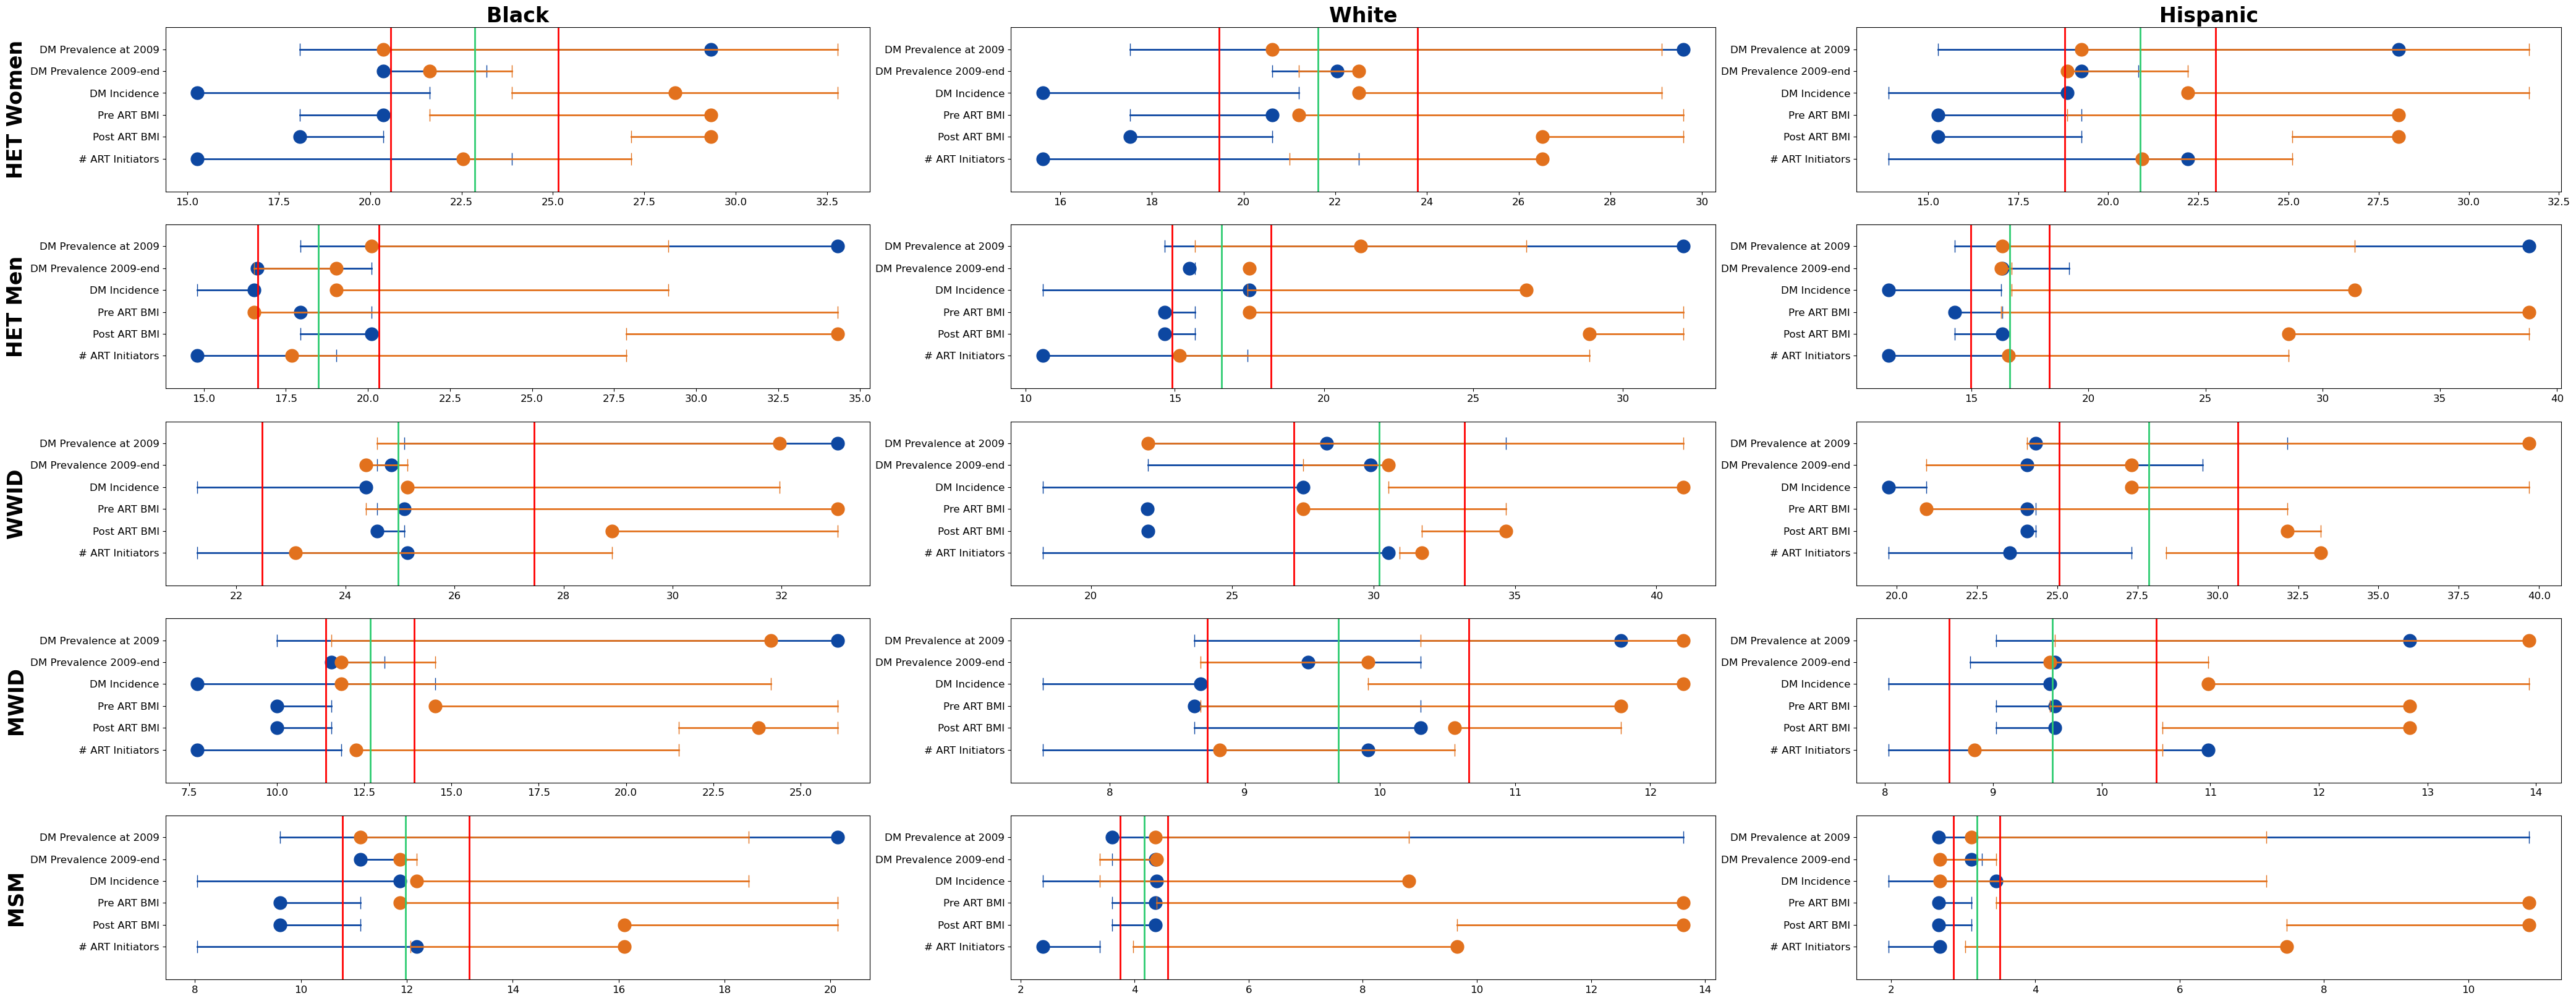

In [32]:
fig = multi_tornado_plot(baseline_tornado_vals, baseline_risk_sa_median)

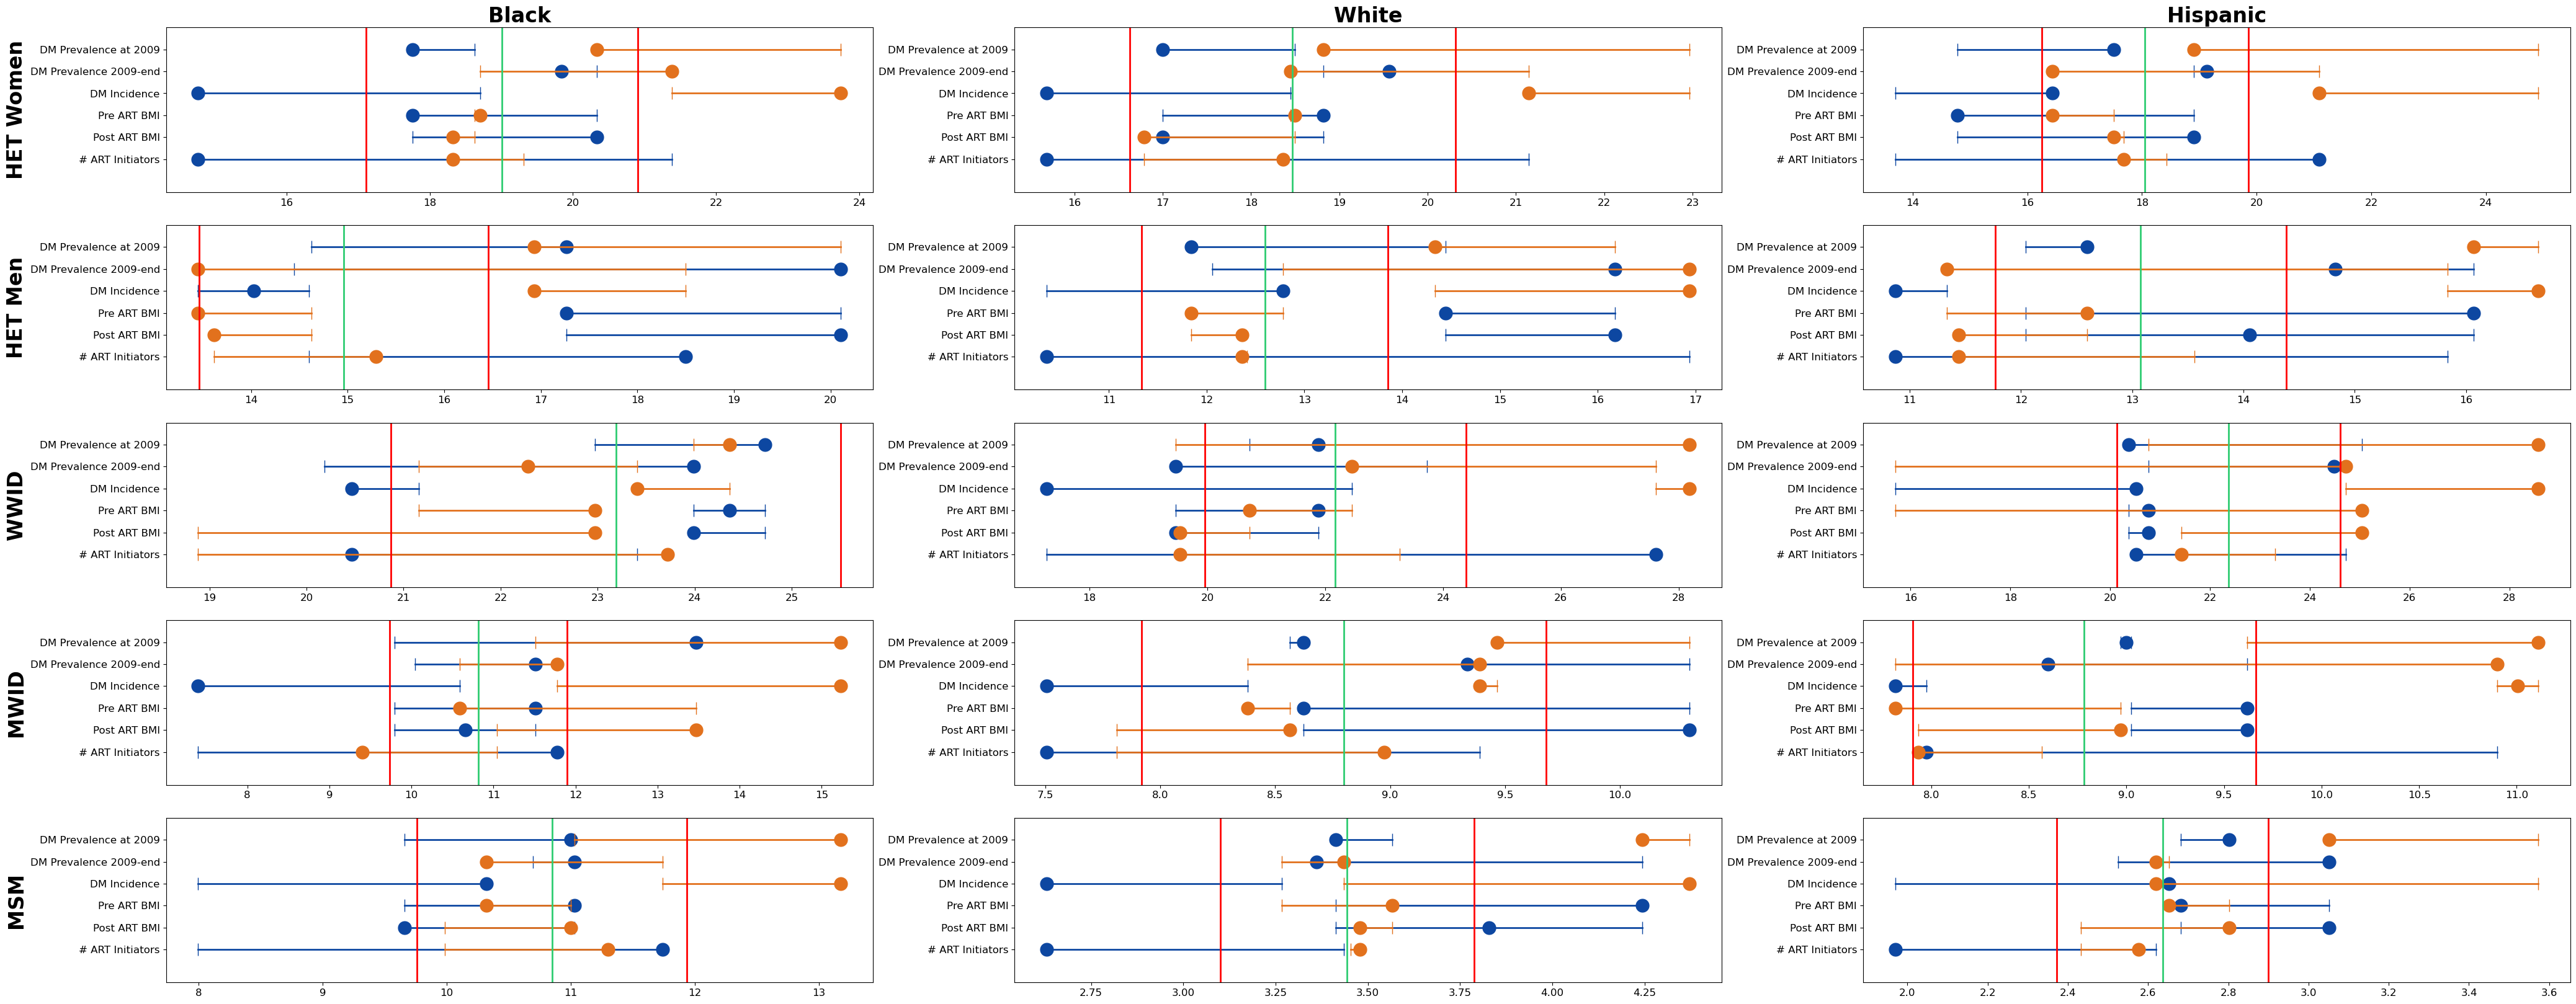

In [33]:
fig = multi_tornado_plot(variable_tornado_vals, variable_risk_sa_median)

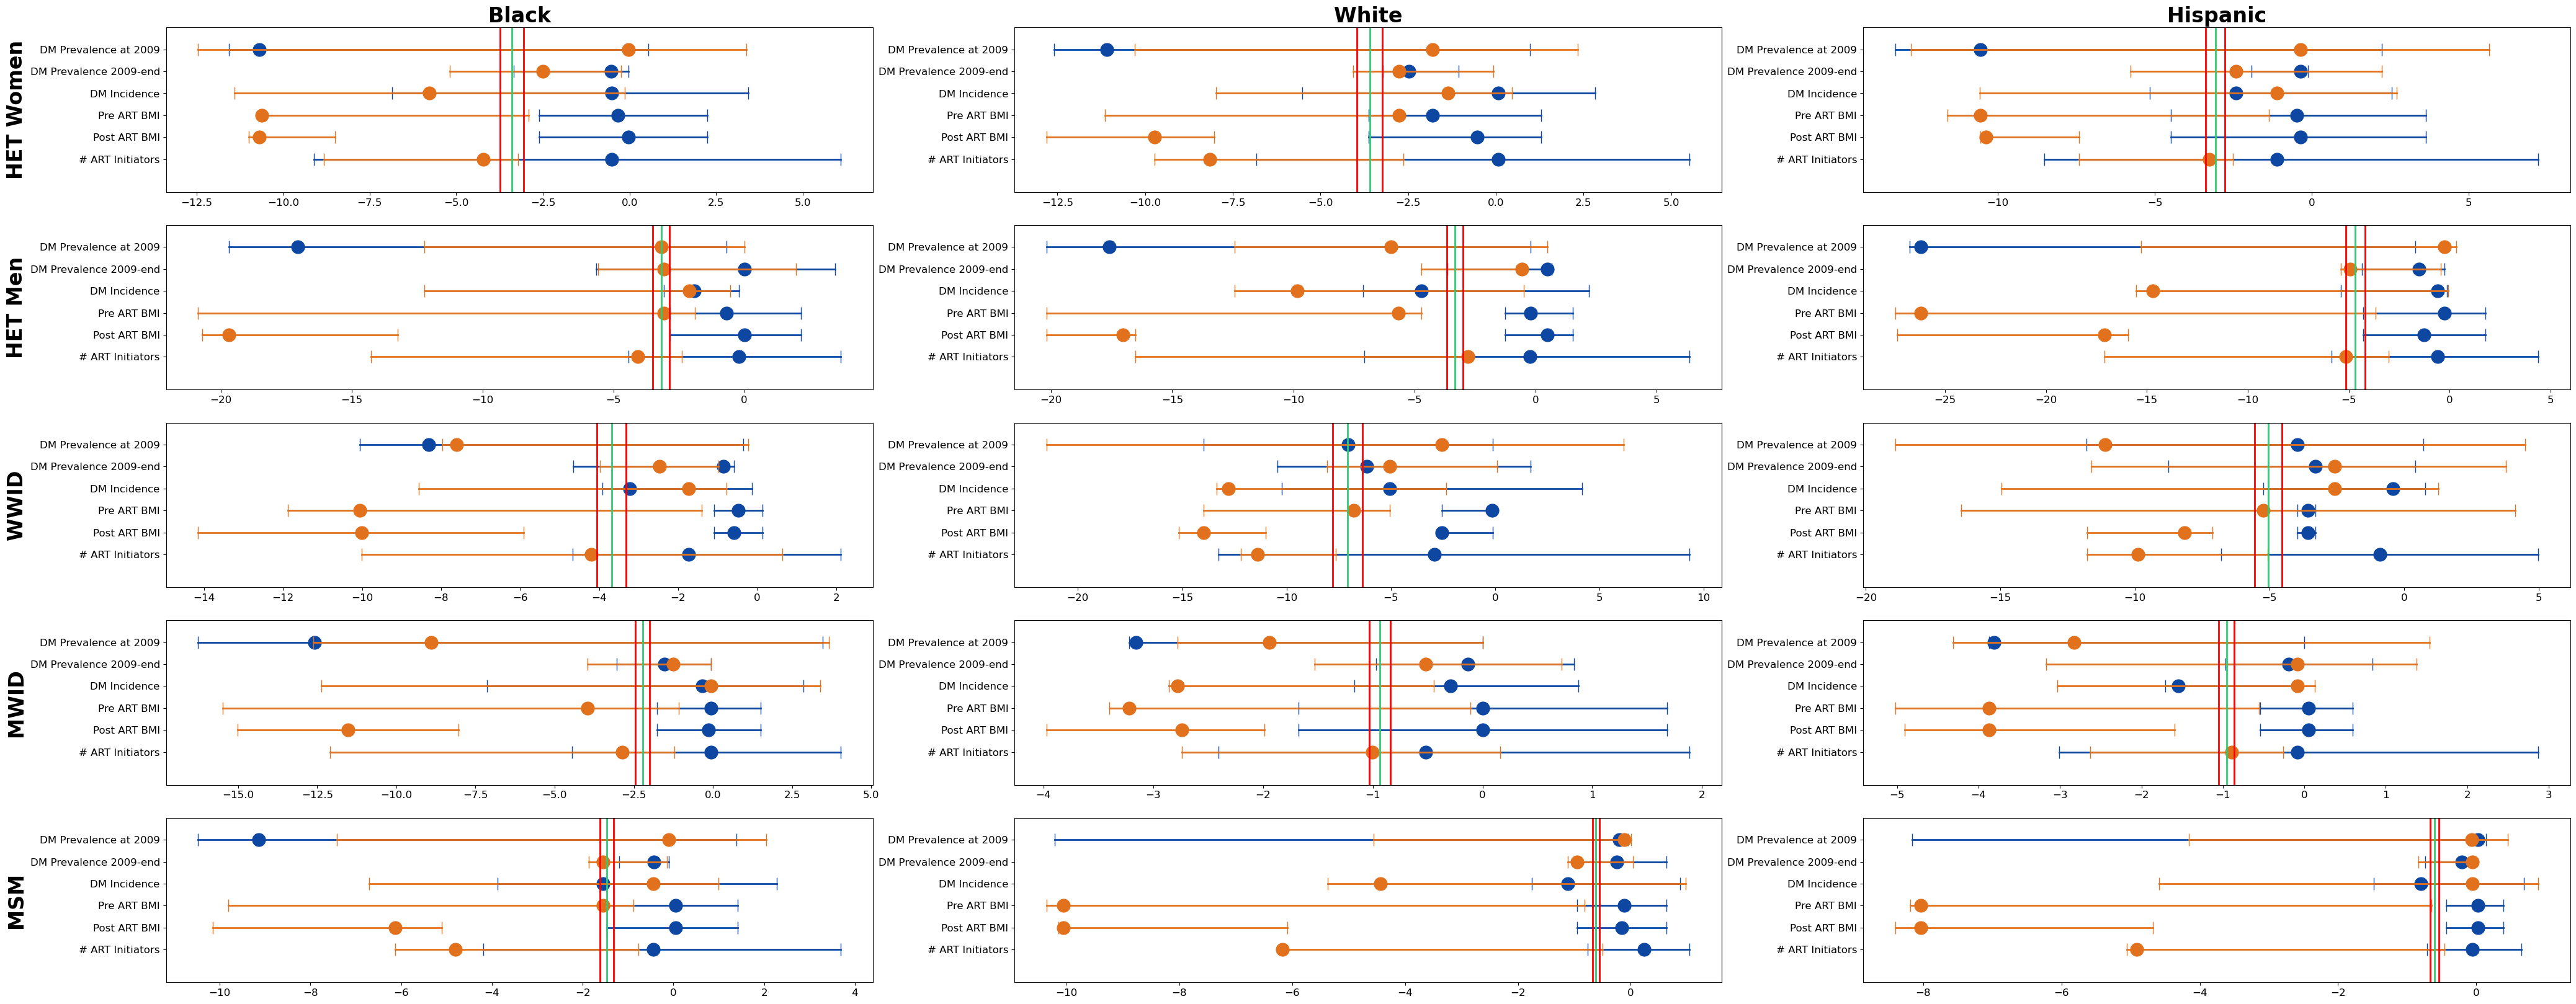

In [34]:
fig = multi_tornado_plot(difference_tornado_vals, baseline_risk_difference_df_sa)

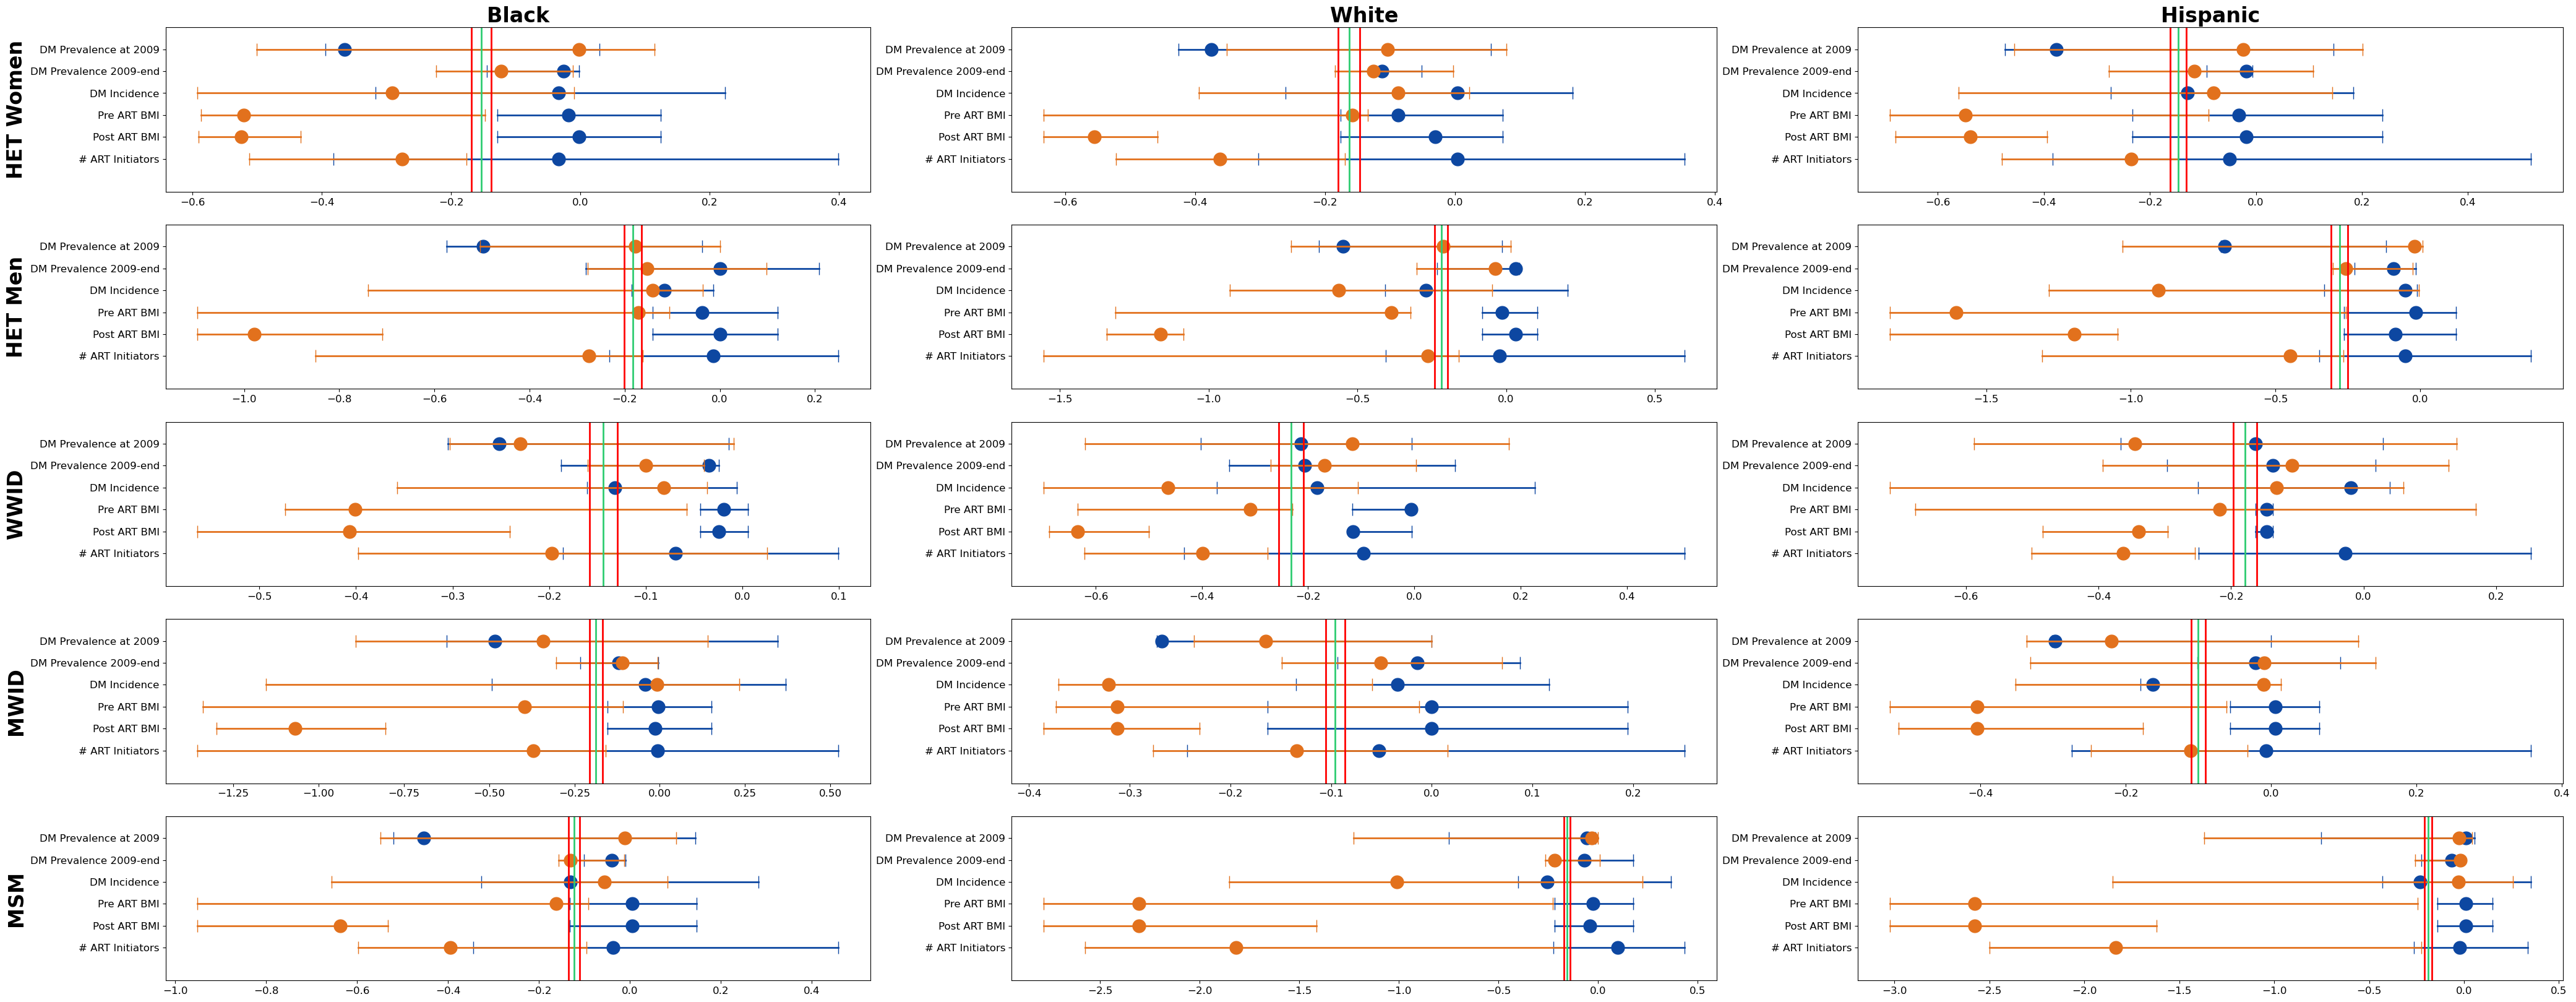

In [35]:
fig = multi_tornado_plot(relative_tornado_vals, baseline_risk_difference_df_sa_relative)

# Overall

In [36]:
def overall_tornado_plot(tornado_vals, baseline_vals):
    # create an axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    group = "overall"

    group_vals = tornado_vals[tornado_vals['group']==group].reset_index(drop=True)
    
    # plot parameters
    y_tick_label = group_vals['variable']
    ys = range(len(y_tick_label))[::-1]
    
    color_lesser = '#0d47a1'
    color_greater = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    lesser_value = group_vals.iloc[:,2].values
    greater_value = group_vals.iloc[:,3].values
    base = baseline_vals[baseline_vals['group']==group]['risk'].values[0]

    # Draw bars
    for y, value, value2 in zip(ys, lesser_value, greater_value):
        
        # draw horizontal line markers for the uncertainty around lesser and greater
        # lesser
        ax.plot((value.iloc[0], value.iloc[2]), (y, y), linewidth=2, color=color_lesser, marker='|', markersize=15)
        ax.plot(value.iloc[1], y , 'o', color=color_lesser, markersize=15)
        
        # greater
        ax.plot((value2.iloc[0], value2.iloc[2]), (y, y), linewidth=2, color=color_greater, marker='|', markersize=15)
        ax.plot(value2.iloc[1], y , 'o', color=color_greater, markersize=15)
        
        

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=2, label='Median value')
    
    # add vertical line for the 90% and 110% of baseline
    ax.axvline(base*0.9, color="red", linewidth=2, label='Median value')
    ax.axvline(base*1.1, color="red", linewidth=2, label='Median value')
    
    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(y_tick_label)
    ax.set_title(group_title_dict[group], fontsize=24, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=16)
        
    return fig
        

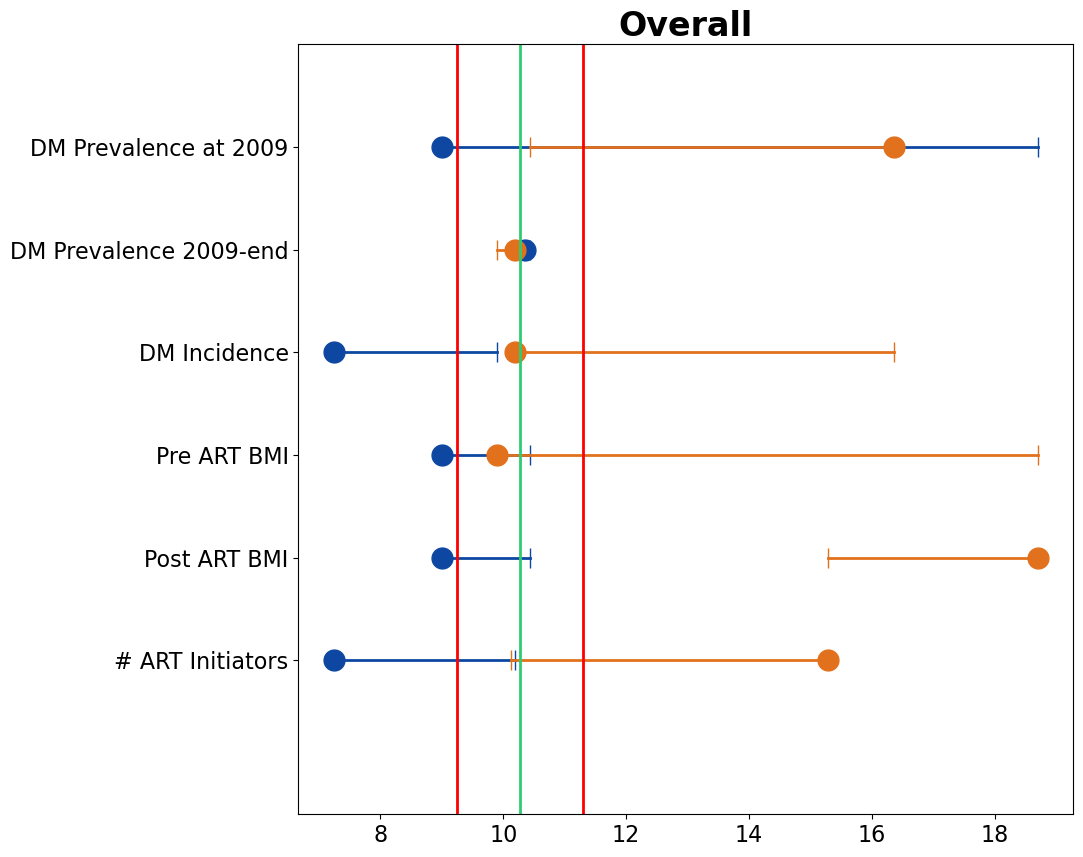

In [37]:
fig = overall_tornado_plot(baseline_tornado_vals, baseline_risk_sa_median)

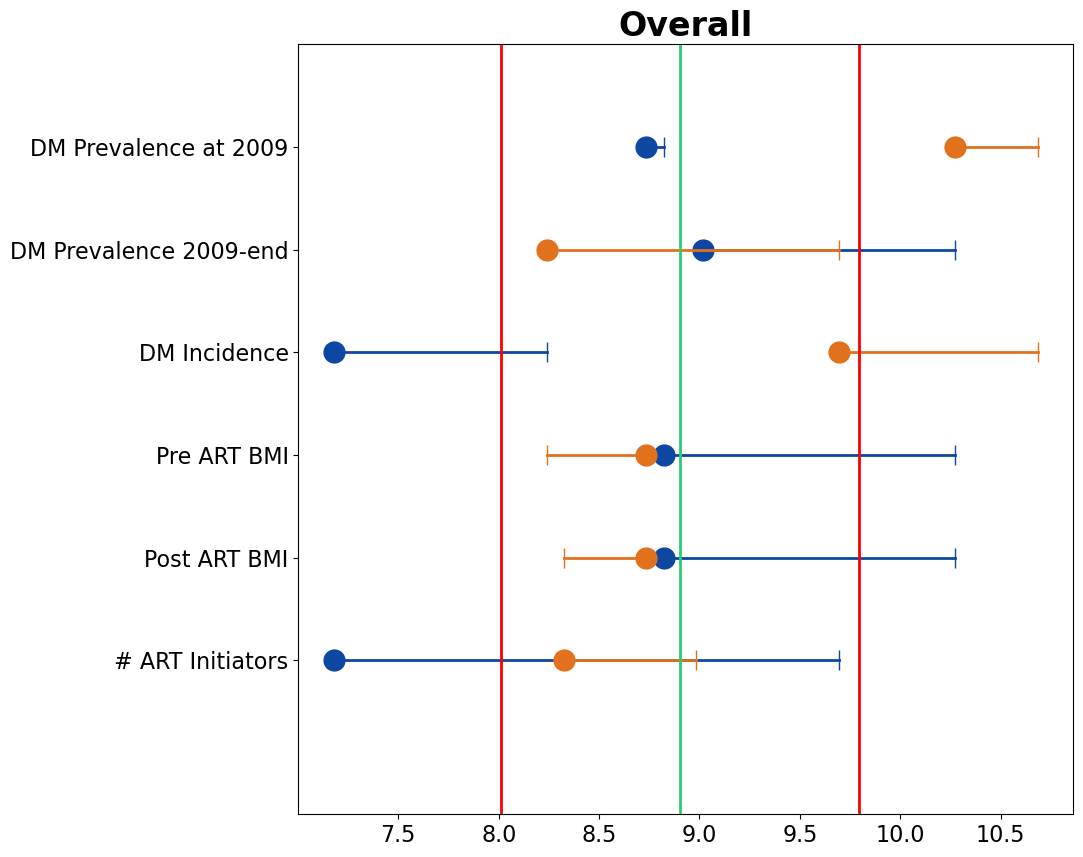

In [38]:
fig = overall_tornado_plot(variable_tornado_vals, variable_risk_sa_median)

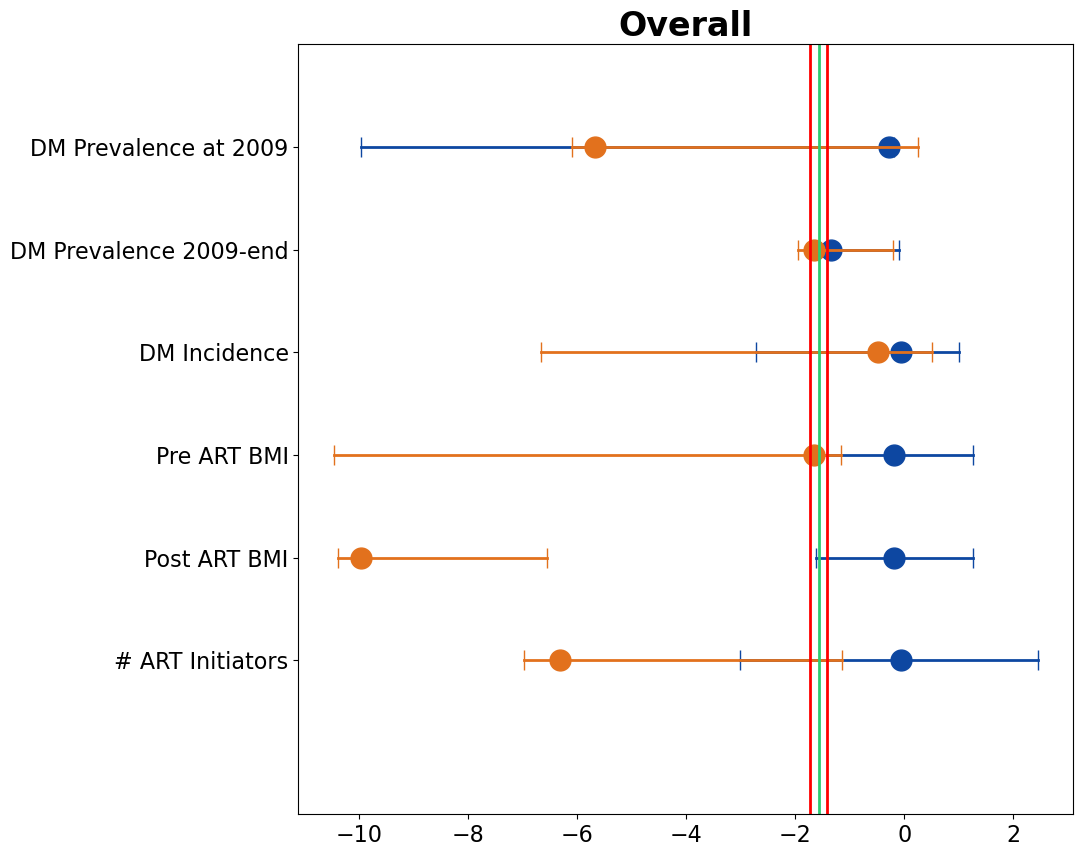

In [39]:
fig = overall_tornado_plot(difference_tornado_vals, baseline_risk_difference_df_sa)

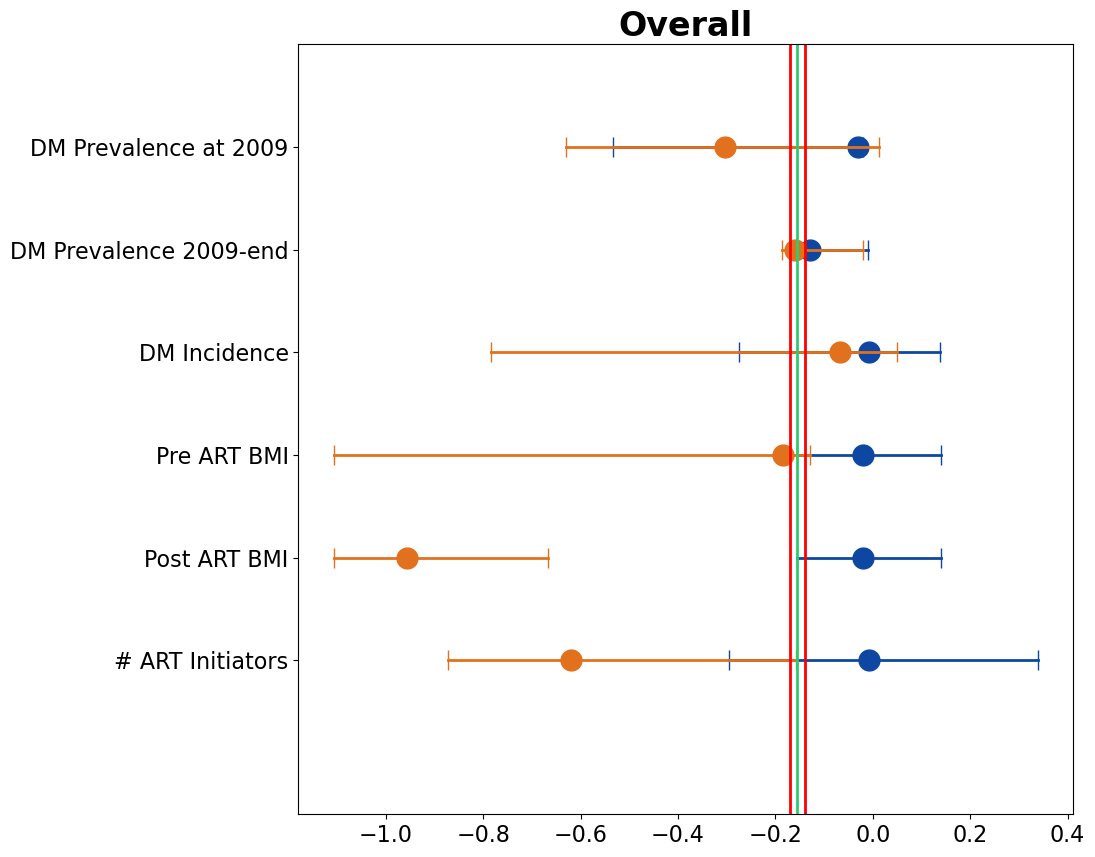

In [40]:
fig = overall_tornado_plot(relative_tornado_vals, baseline_risk_difference_df_sa_relative)